In [160]:
# !pip install -q "tensorflow==2.11.*"
# !pip install -q "tensorflow_io==0.28.*"

In [161]:
# !kaggle datasets download -d warcoder/infant-cry-audio-corpus
# !unzip infant-cry-audio-corpus.zip -d infant-cry

In [162]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import audiomentations as aa

import librosa

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [163]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [164]:
root_dir = 'data/donateacry_corpus'
subfolders = ['belly_pain', 'burping', 'discomfort', 'hungry','tired']

In [165]:
file_paths = []
labels = []

def collect_files_and_labels(base_dir, subfolders, file_paths, labels):
    for folder_name in subfolders:
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(folder_path, file_name)
                    file_paths.append(file_path)
                    labels.append(folder_name)

collect_files_and_labels(root_dir, subfolders, file_paths, labels)

In [166]:
df = pd.DataFrame({
    'File Path': file_paths,
    'Label': labels
})

In [167]:
df

,File Path,Label
0,data/donateacry_corpus\belly_pain\549a46d8-9c8...,belly_pain
1,data/donateacry_corpus\belly_pain\643D64AD-B71...,belly_pain
2,data/donateacry_corpus\belly_pain\643D64AD-B71...,belly_pain
3,data/donateacry_corpus\belly_pain\643D64AD-B71...,belly_pain
4,data/donateacry_corpus\belly_pain\643D64AD-B71...,belly_pain
...,...,...
452,data/donateacry_corpus\tired\d5abedab-9ed5-48d...,tired
453,data/donateacry_corpus\tired\d6cda191-4962-430...,tired
454,data/donateacry_corpus\tired\d6cda191-4962-430...,tired
455,data/donateacry_corpus\tired\d6cda191-4962-430...,tired


In [168]:
# df.to_csv('infant_cry.csv', index=False) 

In [169]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Label'] = label_encoder.fit_transform(labels)

In [170]:
X = df['File Path']
y = df['Label']

In [171]:
X

0      data/donateacry_corpus\belly_pain\549a46d8-9c8...
1      data/donateacry_corpus\belly_pain\643D64AD-B71...
2      data/donateacry_corpus\belly_pain\643D64AD-B71...
3      data/donateacry_corpus\belly_pain\643D64AD-B71...
4      data/donateacry_corpus\belly_pain\643D64AD-B71...
                             ...                        
452    data/donateacry_corpus\tired\d5abedab-9ed5-48d...
453    data/donateacry_corpus\tired\d6cda191-4962-430...
454    data/donateacry_corpus\tired\d6cda191-4962-430...
455    data/donateacry_corpus\tired\d6cda191-4962-430...
456    data/donateacry_corpus\tired\eea17285-4ab9-4d3...
Name: File Path, Length: 457, dtype: object

In [172]:
def train_validate_test_split(df):
    df = df.sample(frac=1).reset_index(drop=True)
    train_end = int(.9 * len(df.index))
    validate_end = int(.05 * len(df.index)) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    return train, validate, test

In [173]:
df_train, df_validation, df_test = train_validate_test_split(df)
print(len(df_train), len(df_validation), len(df_test))

411 22 24


In [174]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [175]:
def wav_map(file_path, label):
    return load_wav_16k_mono(file_path), label

def extract_yamnet_embeddings(wav_data, targets):
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings, tf.repeat(targets, num_embeddings))

# Augmentation

In [176]:
# def add_noise(wav, noise_factor=0.005):
#     noise = tf.random.normal(shape=tf.shape(wav), mean=0.0, stddev=noise_factor, dtype=tf.float32)
#     return wav + noise

# def time_shift(wav, shift_max=1600):
#     shift = tf.random.uniform([], -shift_max, shift_max, dtype=tf.int32)
#     return tf.roll(wav, shift, axis=0)

# def pitch_shift(wav, sampling_rate=16000, pitch_factor=1.1):
#     return tfio.audio.pitch_shift(wav, sampling_rate, pitch_factor)

# def time_stretch(wav, rate=1.1):
#     return tfio.audio.time_stretch(wav, rate)

In [177]:
def add_noise(wav, noise_factor=0.005):
    noise = tf.random.normal(shape=tf.shape(wav), mean=0.0, stddev=noise_factor, dtype=tf.float32)
    return wav + noise

def time_shift(wav, shift_max=1600):
    shift = tf.random.uniform([], -shift_max, shift_max, dtype=tf.int32)
    return tf.roll(wav, shift, axis=0)

def pitch_shift(wav, sampling_rate=16000, pitch_factor=1.1):
    wav_numpy = wav.numpy()
    shifted_wav = librosa.effects.pitch_shift(wav_numpy, sr=sampling_rate, n_steps=pitch_factor)
    return tf.convert_to_tensor(shifted_wav, dtype=tf.float32)

def time_stretch(wav, rate=1.1):
    wav_numpy = wav.numpy()
    stretched_wav = librosa.effects.time_stretch(wav_numpy, rate)
    return tf.convert_to_tensor(stretched_wav, dtype=tf.float32)

# def spec_augment(wav):
#     aug = aa.SpecAugment(time_drop_width=64, time_stripes_num=2, freq_drop_width=8, freq_stripes_num=2)
#     return aug(wav.numpy(), sample_rate=16000)

In [178]:
def augment(wav, label):
    if tf.random.uniform(()) > 0.5:
        wav = add_noise(wav)
    if tf.random.uniform(()) > 0.5:
        wav = time_shift(wav)
    if tf.random.uniform(()) > 0.5:
        wav = pitch_shift(wav)
    if tf.random.uniform(()) > 0.5:
        wav = time_stretch(wav)
    # if tf.random.uniform(()) > 0.5:
    #     wav = tf.py_function(spec_augment, [wav], tf.float32)
    return wav, label

In [179]:
# def process_dataset(dataset, augment_data=False):
#     return (
#         dataset
#         .map(wav_map)
#         if augment_data:
#             .map(augment)
#         .map(extract_yamnet_embeddings)
#         .unbatch()
#         .cache()
#         .shuffle(1000)
#         .batch(32)
#         .prefetch(tf.data.AUTOTUNE)
#     )

In [180]:
def process_dataset(dataset, augment_data=False):
    dataset = dataset.map(wav_map)
    
    if augment_data:
        dataset = dataset.map(augment)
    
    dataset = (
        dataset
        .map(extract_yamnet_embeddings)
        .unbatch()
        .cache()
        .shuffle(1000)
        .batch(32)
        .prefetch(tf.data.AUTOTUNE)
    )
    
    return dataset

In [181]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['File Path'], df_train['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((df_validation['File Path'], df_validation['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((df_test['File Path'], df_test['Label']))

train_ds = process_dataset(train_ds)
valid_ds = process_dataset(valid_ds)
test_ds = process_dataset(test_ds)

train_ds.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [182]:
tf.keras.backend.clear_session()

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_1'),
#     tf.keras.layers.Dense(512, activation='relu', name='dense_1'),
#     tf.keras.layers.Dense(6, activation='softmax', name='output_1')
# ], name='model_criby')


#87 val
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),  # Assuming the YAMNet embeddings have a shape of (1024,)
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(5, activation='softmax')  # Adjust the number of classes as needed
])

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1024,)),  # Assuming the YAMNet embeddings have a shape of (1024,)
#     tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(5, activation='softmax')  # Adjust the number of classes as needed
# ])



# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(None, 1024)),  # Assuming YAMNet embeddings are of variable length
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.LSTM(32),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])

In [183]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

c:\Users\wikab\python-gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [184]:
history = model.fit(train_ds, 
                    epochs=50, 
                    validation_data=valid_ds, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
179/179 [==============================] - 22s 100ms/step - loss: 4.3669 - accuracy: 0.1787 - val_loss: 3.4240 - val_accuracy: 0.1115 - lr: 1.0000e-04
Epoch 2/50
179/179 [==============================] - 2s 10ms/step - loss: 4.0582 - accuracy: 0.1981 - val_loss: 3.2778 - val_accuracy: 0.1311 - lr: 1.0000e-04
Epoch 3/50
179/179 [==============================] - 2s 12ms/step - loss: 3.8484 - accuracy: 0.2055 - val_loss: 3.1114 - val_accuracy: 0.1705 - lr: 1.0000e-04
Epoch 4/50
179/179 [==============================] - 2s 12ms/step - loss: 3.6114 - accuracy: 0.2301 - val_loss: 2.9888 - val_accuracy: 0.1869 - lr: 1.0000e-04
Epoch 5/50
179/179 [==============================] - 2s 12ms/step - loss: 3.4146 - accuracy: 0.2544 - val_loss: 2.8513 - val_accuracy: 0.2131 - lr: 1.0000e-04
Epoch 6/50
179/179 [==============================] - 2s 12ms/step - loss: 3.2833 - accuracy: 0.2745 - val_loss: 2.7383 - val_accuracy: 0.2787 - lr: 1.0000e-04
Epoch 7/50
179/179 [==================

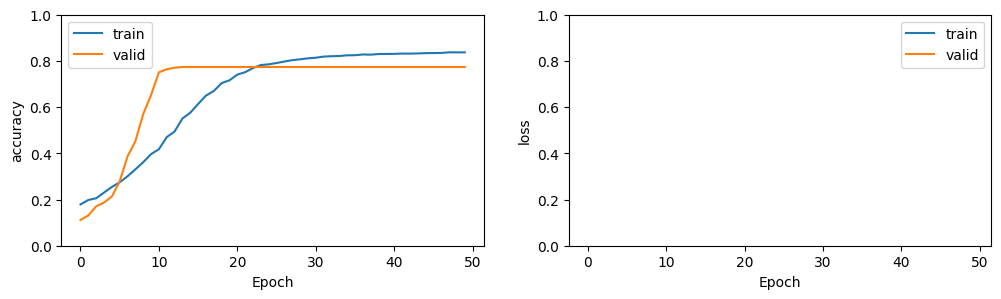

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    ax[i].set_ylim([0, 1])
    ax[i].legend(['train', 'valid'])

plt.show()

In [186]:
results = model.evaluate(test_ds, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Accuracy: {results[1]}')

Test Loss: 1.0537495613098145
Test Accuracy: 0.8333333134651184


In [187]:
model.save("model.h5")